# Part 1A: Sampling, measurement and forward models

In [1]:
# IPython magics
%matplotlib inline

In [2]:
# Import packages
import matplotlib
#matplotlib.rc('text', usetex=True)
import matplotlib.pyplot as plt
import matplotlib.image
import seaborn as sb
import numpy as np
import scipy.stats as stats
import scipy.constants as consts
import scipy.ndimage
from scipy.ndimage.filters import gaussian_filter

## The Poisson distribution

In a particular pixel of a detector we expect an average count rate rate of $R_\mu$ counts/s and over an interval. If the detector counts for a period $\tau$ then we would expect an average of $C_\mu=R_\mu\tau$ counts over that accumulation (also known as an integration). Counts might also be known as a "data number" (DN).

The number of actual counts, $C$ recorded is a random variable following a Poisson distribution: $C\sim \textrm{Pois}(C_\mu)$. A Poisson distribution is a discrete probability distribution expressing the probability of a number of events occuring in a fixed temporal or spatial interval. The events must occur at a constant rate and the rate must be independent of time since the last event.

\\( P(C) = \exp(-C_\mu)\frac{C_\mu^k}{C!} \\)

Let's plot the probability mass function (PMF) for the Poisson distribution, with a mean of 5, and then generate some random samples for $C$ and compare the distribution.

One basic property of a probability distribution is that they should normalise to unity - the probability distribution should contain all possible outcomes. Hence, for the Poisson distribution, $\sum_{k=0}^{k=\infty} P(k)=1$.

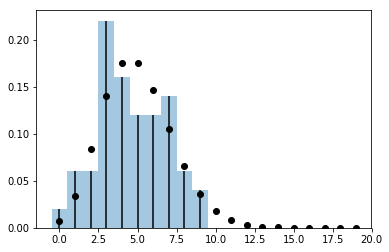

In [3]:
# This is the mean of the distribution
C_mu = 5

# Generate some random samples.
C_i = stats.poisson.rvs(C_mu, size=50)

# Draw histogram using Seaborn.
sb.distplot(C_i, bins=np.arange(0,20,1)-0.5, kde=False, norm_hist=True)

# Overplot exact PMF.
C = np.arange(0,20,1)
y = stats.poisson.pmf(C,5)
plt.plot(C,y,'ok')

# Let's also do the histogram ourselves - because we can. Use NumPy's histogram function and do the normalisation ourselves.
h = np.histogram(C_i, bins=np.arange(0,20,1)-0.5) # h[0] contains the number of samples in each bin, [1] contains the bin edges
h0 = np.array(h[0])
h0 = h0/np.sum(h0)
C_bin_centre = (h[1][:-1] + h[1][1:])/2.0
plt.vlines(C_bin_centre, [0], h0)

## Poisson distributions and pixel values
Here we are going to generate a synthetic image using a source image (the ESA logo) as a basis. We can use this to experiment with how various measurement effects combine to affect the final measurement. We will be building a rudimentary forward model.

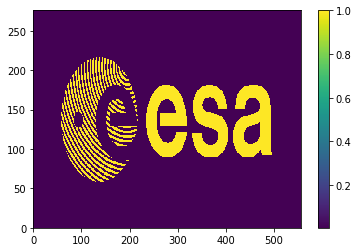

In [4]:
# Load an image, only keep one of the channels since we just want a count rate, and vertically invert it.
# The shape will become our mean count rate, at the moment the image data is either 0 or 1, so we will scale to 
# a maximum of 10 for a mean count rate of 10 counts/s.
image_data = matplotlib.image.imread("data/esa-logo.png")
image_data = np.flipud(image_data[:,:,0])
image_width = image_data.shape[1]
image_height = image_data.shape[0]
data = image_data*10.0
plt.pcolor(image_data)
plt.colorbar()

Now take the image data and push it through a forward model, including noise, an optical distortion, and a filter to slightly blur the image (simulating what might happen in the optics).

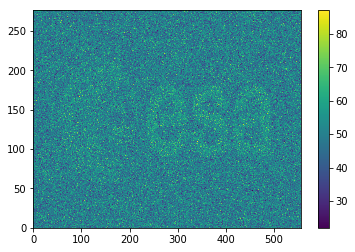

In [5]:
# Define noise level (100 counts/s here)
noise = np.zeros(image_data.shape) + 100

# Generate a distortion that changes the intensity across the image - simulates
# the effect of optics making the image brighter in the middle.
ix,iy = np.meshgrid(range(0,image_width),range(0,image_height))
distort = np.exp(-((ix-image_width/2)/(image_width))**2 - ((iy-image_height/2)/(image_height*2))**2)

# Apply a Gaussian filter to simulate a point spread function, multiply by a factor that changes the intensity across the
# image to simulate the effect of optics making the image brighter in the middle, then add the noise. This gives the final
# mean counts/s per pixel that will be the mean for a Poisson distribution for each pixel. Where each pixel is a
# Poisson RV.
C_mu = gaussian_filter(data, sigma=1)*distort + noise
#plt.pcolor(C_mu)

# Now we can randomly sample an image using a Poisson random number generator.
tau = 0.5 # integration time [s]
C = np.random.poisson(C_mu*tau, size=C_mu.shape)
plt.pcolor(C)
plt.colorbar()

Finally, let's pretend that we can only return images where each pixel can only range between 0-2^n-1. Effectively we are saying each pixel can use up n bits of information. This limits the dynamic range of the measurement.

In [6]:
n_bits = 6
C[(C>(2**n_bits-1))] = (2**n_bits-1)
C = C & (2**n_bits-1)

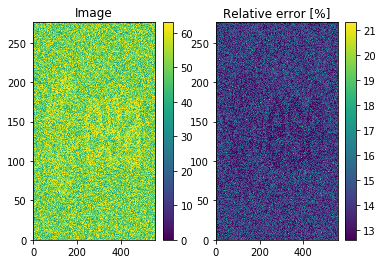

In [7]:
plt.subplot(1,2,1)
plt.pcolor(C)
plt.title('Image')
plt.clim([0,(2**n_bits-1)])
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolor(np.sqrt(C.astype(np.float))*100/C.astype(np.float))
plt.title('Relative error [%]')
plt.colorbar()


## Experimentation
There are a number of elements for experimentation. Try reducing or increasing the integration time (tau), try increasing or reducing the mean counts/s to make the foreground more or less intense, try increasing or reducing the noise level. Try reducing or increasing the bit depth.

Extremes:
1. low signal, high noise, small bit depth, short integration time.
2. high signal, low noise, large bit depth, long integration times.

Does the image saturate for certain combinations? What combinations give an invisible image? Can you increase the level of smoothing (point spread function) so that the stripes in the logo are obscured?